<a href="https://colab.research.google.com/github/rakshajp/solar-research/blob/main/proof_of_concept_solar__CNN_to_detect_PV_installations__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
IMPORT REQUIRED LIBRARIES AND FUNCTIONS
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import filters
from skimage import color
from skimage.color import rgb2gray

# from keras.utils import print_summary
from keras.metrics import categorical_accuracy
from keras import losses
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalMaxPooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.models import Sequential
import keras.backend as K

import tensorflow as tf

import random

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Share dataset to repo

drive_data_path = "/content/drive/MyDrive/arathee_solar_dataset"

Mounted at /content/drive


In [ ]:
# # temp code to rename neg folder files to test new imgs

# import os
# folder_path = drive_data_path + '/negative'
# os.chdir(folder_path)

# count = 1500  # Starting count

# for filename in os.listdir(folder_path):
#     if os.path.isfile(os.path.join(folder_path, filename)):
#         # Get the file extension
#         file_ext = filename.split('.')[-1]
#         # Create the new name with the incremented count
#         new_name = str(count) + '.' + file_ext
#         # Rename the file
#         os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))
#         count += 1  # Increment count for the next file

# print('all done!')



all done!


In [ ]:
!pip install Pillow

In [ ]:
# from PIL import Image

# # Replace '1.jpg' with the name of the image file you want to examine
# image_file = drive_data_path + "/training/1.tif"

# # Open the image
# img = Image.open(image_file)

# # Print image details
# print(f"Image Format: {img.format}")
# print(f"Image Mode: {img.mode}")
# print(f"Image Size: {img.size}")


Image Format: TIFF
Image Mode: RGB
Image Size: (101, 101)


In [ ]:

# # Define the paths
# input_folder = drive_data_path+'/negative'
# output_folder = drive_data_path+'/negative_modified'

# # Create the output folder if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# count = 1500  # Starting count

# # Iterate through all files in the input folder
# for filename in os.listdir(input_folder):
#     if os.path.isfile(os.path.join(input_folder, filename)):
#         # Open the image
#         img = Image.open(os.path.join(input_folder, filename))

#         # Modify the image properties
#         img = img.convert('RGB')  # Convert to RGB mode
#         img = img.resize((101, 101), Image.ANTIALIAS)  # Resize to 101x101 pixels

#         # Save the modified image in the output folder
#         new_filename = str(count) + '.tif'
#         img.save(os.path.join(output_folder, new_filename), 'TIFF')

#         count += 1  # Increment count for the next file

# print("All files have been modified and saved in the output folder.")


In [ ]:
'''
LOADING DATA AND PREPROCESSING
'''
from tqdm import tqdm

def load_data(dir_data, dir_labels, training=True):
    '''
    Load each of the image files into memory
    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory.
    When training=True, the labels are also loaded.
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids = labels_pd.id.values
    data = []
    for identifier in tqdm(ids):
        fname = dir_data + identifier.astype(str) + '.tif'
        image = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data)  # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    pass


# define dataset directories
DIR_TRAIN_IMAGES = drive_data_path + "/training/"
DIR_TEST_IMAGES = drive_data_path + "/testing/"
# DIR_TEST_IMAGES = drive_data_path + "/negative_modified/"
DIR_TRAIN_LABELS = drive_data_path + "/labels_training.csv"
DIR_TEST_IDS = drive_data_path + "/sample_submission.csv"

# load train and test data
X, y = load_data(DIR_TRAIN_IMAGES, DIR_TRAIN_LABELS)
X_test, test_ids = load_data(DIR_TEST_IMAGES, DIR_TEST_IDS, training=False)

# print data shape
print('X shape:\n', X.shape)
print('X_test shape:\n', X_test.shape)

# check number of samples in each class
print('Distribution of y', np.bincount(y))

# scale pixel values between 0 and 1
X = X / 255.0
X_test = X_test / 255.0


100%|██████████| 558/558 [03:16<00:00,  2.84it/s]

X shape:
 (1500, 101, 101, 3)
X_test shape:
 (558, 101, 101, 3)
Distribution of y [995 505]


In [ ]:

'''
MODEL 1: LOGISTIC REGRESSION TRAINED ON HOG FEATURES
'''

def preprocess_and_extract_features(data):
    '''
    Input  : RGB images as tensors
    Output : Standardized HOG features
    '''
    fd_all = []
    for row in data:
        resized_img = resize(row, (100, 100))
        # extract HOG features
        fd = hog(resized_img, orientations=9, pixels_per_cell=(20, 20),
                 cells_per_block=(5, 5), visualize=False, multichannel=True)
        fd_all.append(fd)
        pass
    fd_all = np.array(fd_all)
    features = fd_all

    # standardize features
    ss = StandardScaler()
    ss.fit(features)
    features = ss.transform(features)

    return features

# cross-validator
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment
    Input:
        X   : training data
        y   : training labels
        k   : number of folds for cross validation
        clf : classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')
    prediction_class = np.empty(y.shape[0], dtype='object')

    # establish the k folds
    random_seed = 1
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    for train_index, val_index in kf.split(X, y):
        # extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        # train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf = clf.fit(X_train_features, y_train)

        # test the classifier on the validation data for this fold
        X_val_features = preprocess_and_extract_features(X_val)
        y_val_pred_probs = clf.predict_proba(X_val_features)
        y_val_pred_class = clf.predict(X_val_features)

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs[:, 1]
        prediction_class[val_index] = y_val_pred_class

    return prediction_scores, prediction_class


# define baseline model
base_model = LogisticRegression(solver='lbfgs')

# cross-validate baseline model
num_folds = 5
random_seed = 1
baseline_y_hat_prob, baseline_y_hat_class = cv_performance_assessment(
    X, y, num_folds, base_model, random_seed=random_seed)



<ipython-input-39-646adbe3850b>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(20, 20),
<ipython-input-39-646adbe3850b>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(20, 20),
<ipython-input-39-646adbe3850b>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(20, 20),
<ipython-input-39-646adbe3850b>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(20, 20),
<ipython-input-39-646adbe385

In [ ]:
'''
MODEL 2: K-NEAREST NEIGHBOR TRAINED ON HOG FEATURES
'''

# PART 1: Searching for best hyperparameters

def preprocess_and_extract_features(data):
    '''
    Input  : RGB images as tensors
    Output : Standardized HOG features
    '''
    fd_all = []
    for row in tqdm(data):
        resized_img = resize(row, (100, 100))
        # create hog features
        fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),
                 cells_per_block=(2, 2), visualize=False, multichannel=True)
        fd_all.append(fd)
        pass
    fd_all = np.array(fd_all)
    features = fd_all

    # standardize HOG features
    ss = StandardScaler()
    ss.fit(features)
    features = ss.transform(features)

    return features

# define hyperparameter space
k_range = list(range(1, 31))
p_range = list(range(1, 4))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, p=p_range, weights=weight_options)

# search over hyperparameter space using cross-validation
num_folds   = 5
random_seed = 5
clf         = KNeighborsClassifier()
search      = RandomizedSearchCV(clf, param_dist, cv=num_folds, scoring='roc_auc', n_iter=10, random_state=random_seed)
search.fit(preprocess_and_extract_features(X), y)

# look at best parameters
print(search.best_params_)

  0%|          | 0/1500 [00:00<?, ?it/s]<ipython-input-40-4788a32edfbd>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),
100%|██████████| 1500/1500 [00:08<00:00, 176.12it/s]


{'weights': 'distance', 'p': 1, 'n_neighbors': 5}


  0%|          | 0/1200 [00:00<?, ?it/s]<ipython-input-40-4788a32edfbd>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),
  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-40-4788a32edfbd>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),
  0%|          | 0/1200 [00:00<?, ?it/s]<ipython-input-40-4788a32edfbd>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd = hog(resized_img, orientations=9, pixels_per_cell=(15, 15),
  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-40-4788a32edfbd>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It wil

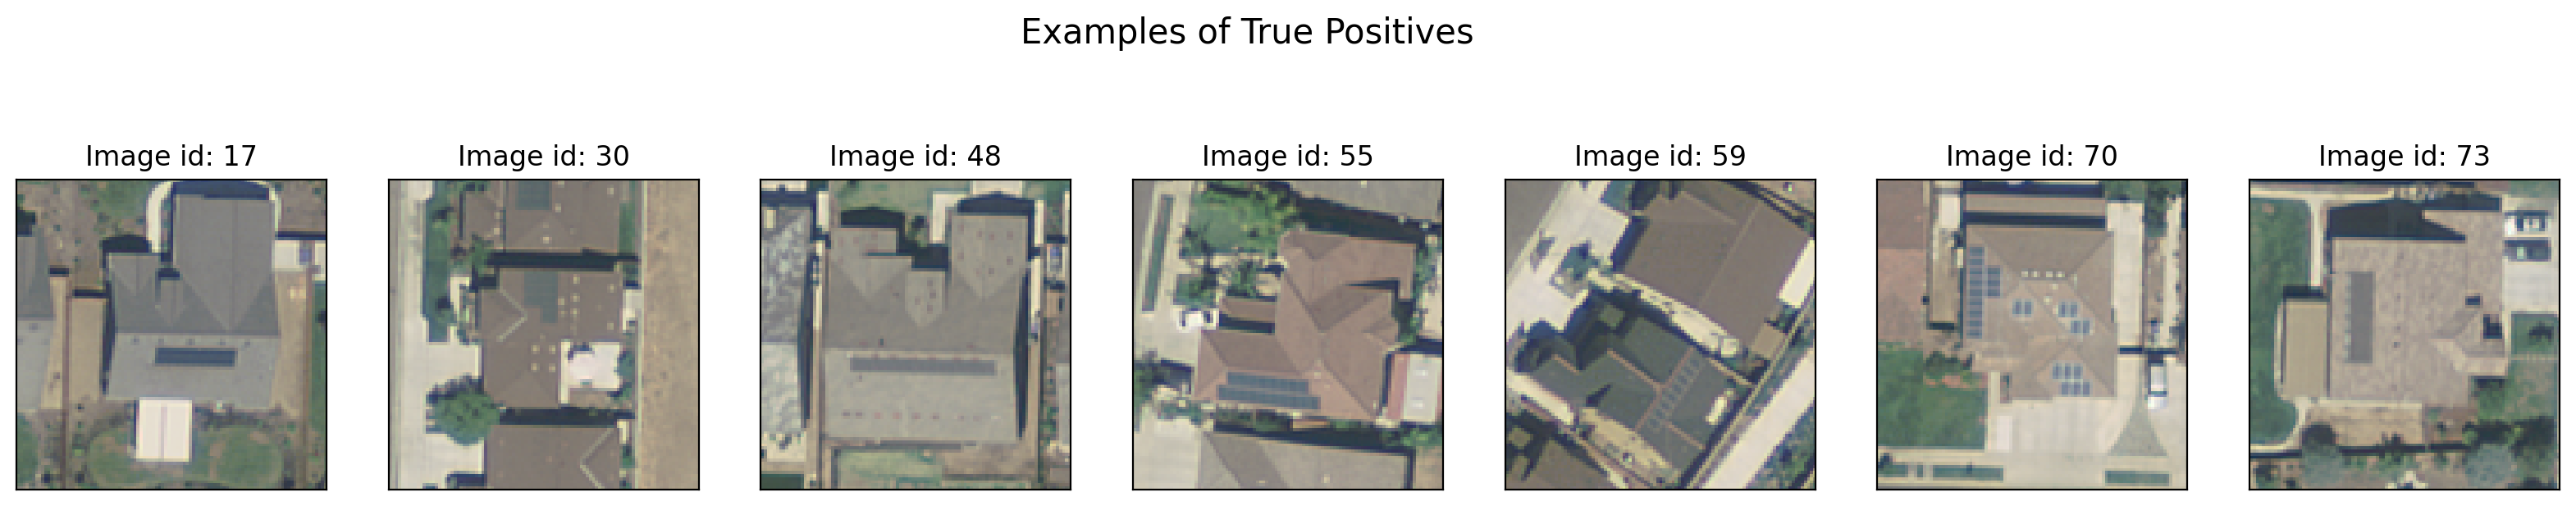

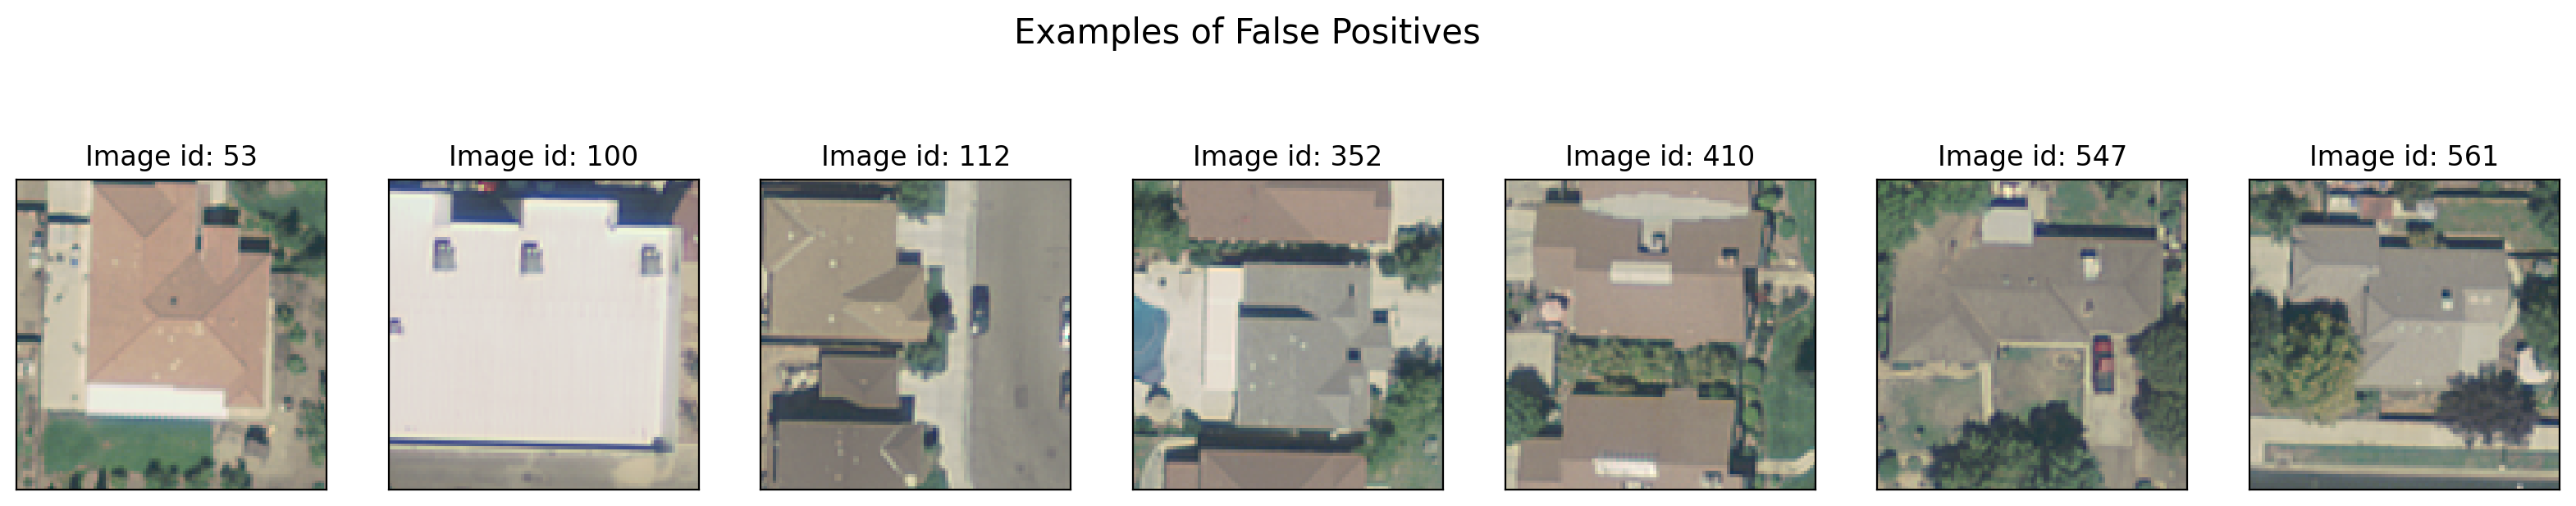

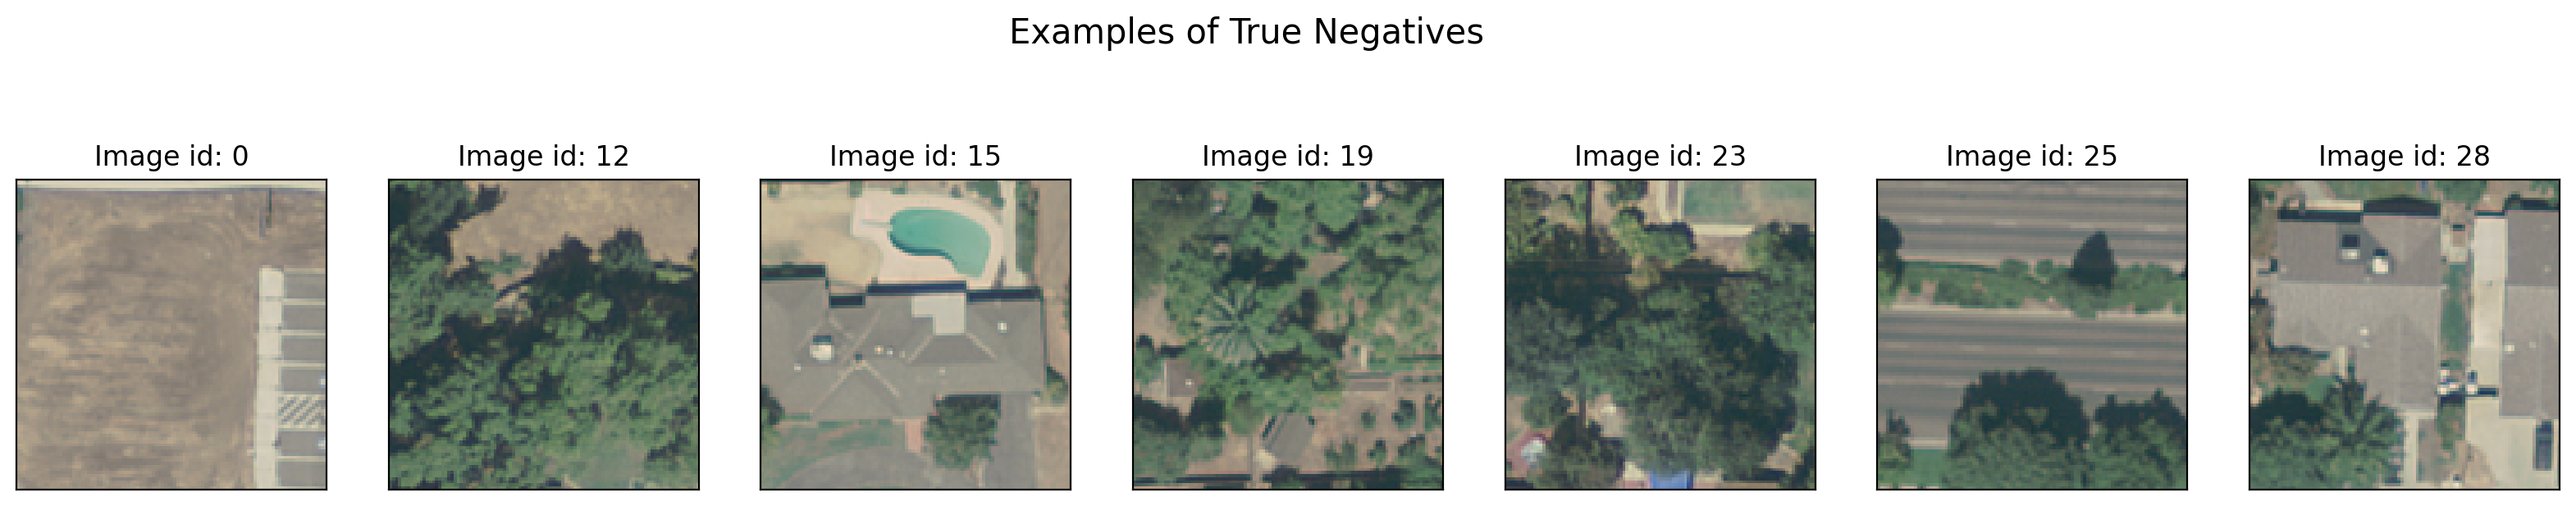

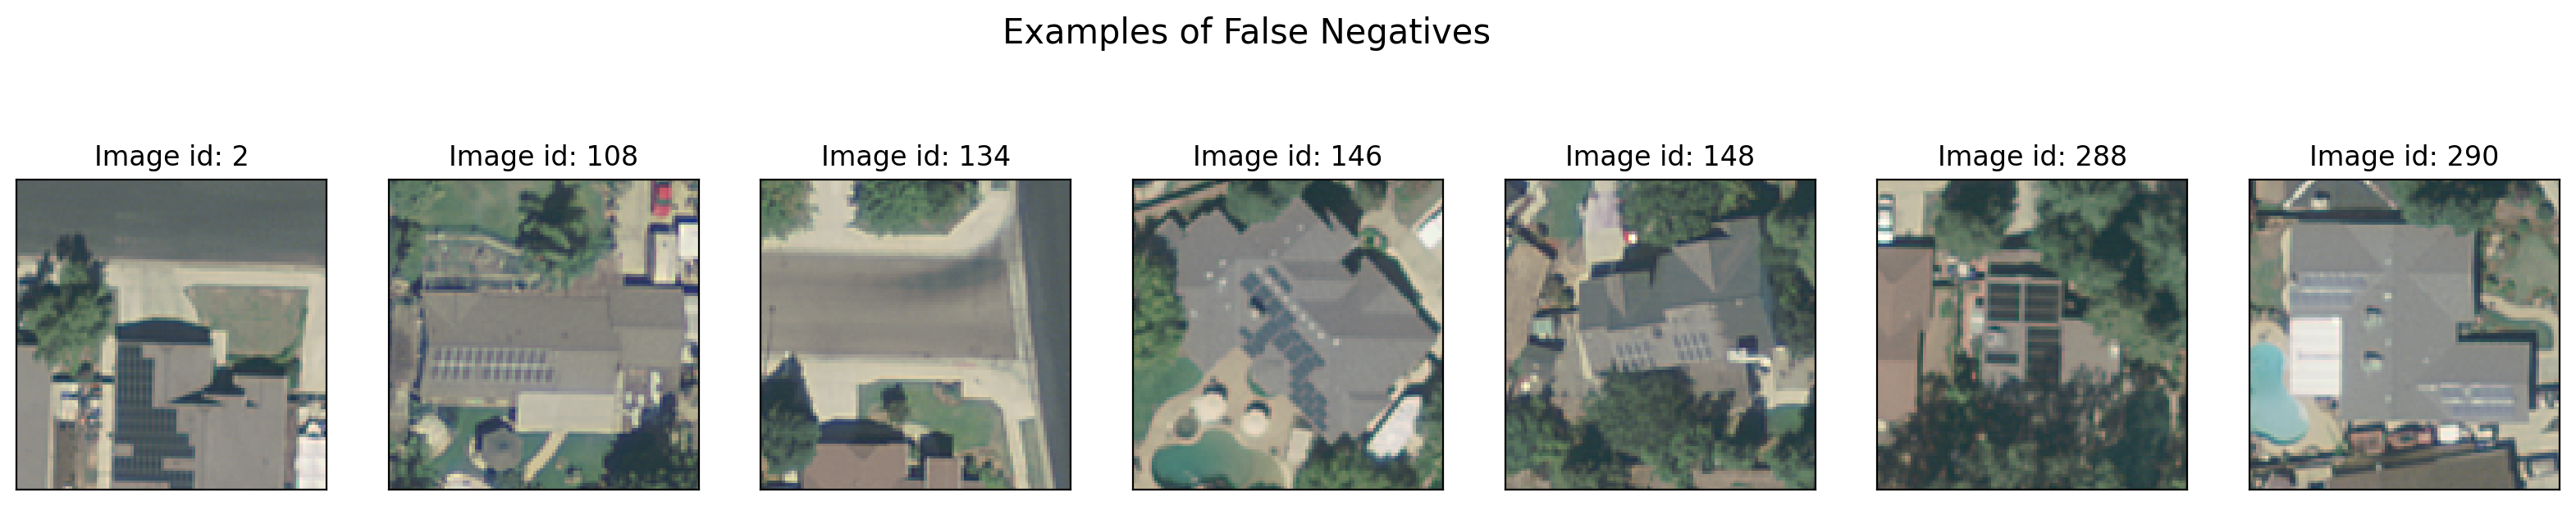

In [ ]:
# PART 2: Fit KNN using the best hyperparameters
k      = search.best_params_['n_neighbors']
p      = search.best_params_['p']
weight = search.best_params_['weights']
knn    = KNeighborsClassifier(n_neighbors=k, p=p, weights=weight)

# cross-validate to have realistic idea of model performance on test set
num_folds   = 5
random_seed = 1
hog_knn_y_hat_prob, hog_knn_y_hat_class = cv_performance_assessment(X, y, num_folds, knn, random_seed=random_seed)

# Look at TP, TN, FP, and FN
def show_images(image_ids, num_images, title):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4
    plt.figure()
    n = 1
    for i in image_ids[0:num_images]:
        plt.subplot(1, num_images, n)
        plt.imshow(X[i, :, :, :])
        plt.title('Image id: ' + str(i))
        plt.xticks([])
        plt.yticks([])
        n += 1
        pass

    plt.suptitle(title, fontsize=15)
    plt.show()
    pass


df = pd.read_csv(DIR_TRAIN_LABELS)
df["predicted_score"] = hog_knn_y_hat_prob

fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])

num_images = 7  # number of images to look at
show_images(tp, num_images, 'Examples of True Positives')
show_images(fp, num_images, 'Examples of False Positives')
show_images(tn, num_images, 'Examples of True Negatives')
show_images(fn, num_images, 'Examples of False Negatives')


In [ ]:
# Look at TP, TN, FP, and FN
def show_images(image_ids, num_images, title):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4
    plt.figure()
    n = 1
    for i in image_ids[0:num_images]:
        plt.subplot(1, num_images, n)
        plt.imshow(X[i, :, :, :])
        plt.title('Image id: ' + str(i))
        plt.xticks([])
        plt.yticks([])
        n += 1
        pass

    plt.suptitle(title, fontsize=15)
    plt.show()
    pass



In [ ]:
'''
MODEL 3: CONVOLUTIONAL NEURAL NETWORK
'''

# define CNN
def build_model():
    '''
    Returns a Keras CNN model
    '''

    # define image dimensions
    IMAGE_HEIGHT = 101
    IMAGE_WIDTH = 101
    IMAGE_CHANNELS = 3

    # define a straightforward sequential neural network
    model = Sequential()

    # layer-1
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  IMAGE_CHANNELS)))
    model.add(BatchNormalization())

    # layer-2
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # max-pool
    model.add(MaxPooling2D(pool_size=2))

    # layer-4
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-5
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # max-pool
    model.add(MaxPooling2D(pool_size=2))

    # layer-6
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-7
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # global-max-pool
    model.add(GlobalMaxPooling2D())

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [ ]:
# cross-validate CNN model
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment
    Input:
        X   : training data
        y   : training labels
        k   : number of folds for cross validation
        clf : classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')
    prediction_class = np.empty(y.shape[0], dtype='object')

    # establish the k folds
    random_seed = 1
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    for train_index, val_index in kf.split(X, y):
        # extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        # give more weight to minority class based on the target class distribution
        class_weight = {0: 505/1500, 1: 995/1500}

        # train the classifier
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=40,
                           shuffle=True,
                           verbose=0)

        # test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs

    return prediction_scores


num_folds      = 3
random_seed    = 1
cnn            = build_model()
cnn.summary()
cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

# Look at TP, TN, FP, and FN
df = pd.read_csv(DIR_TRAIN_LABELS)
df["predicted_score"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]

fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 99, 99, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 99, 99, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 97, 97, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 95, 95, 128)       73856     
                                                                 
 batch_normalization_9 (Bat  (None, 95, 95, 128)      

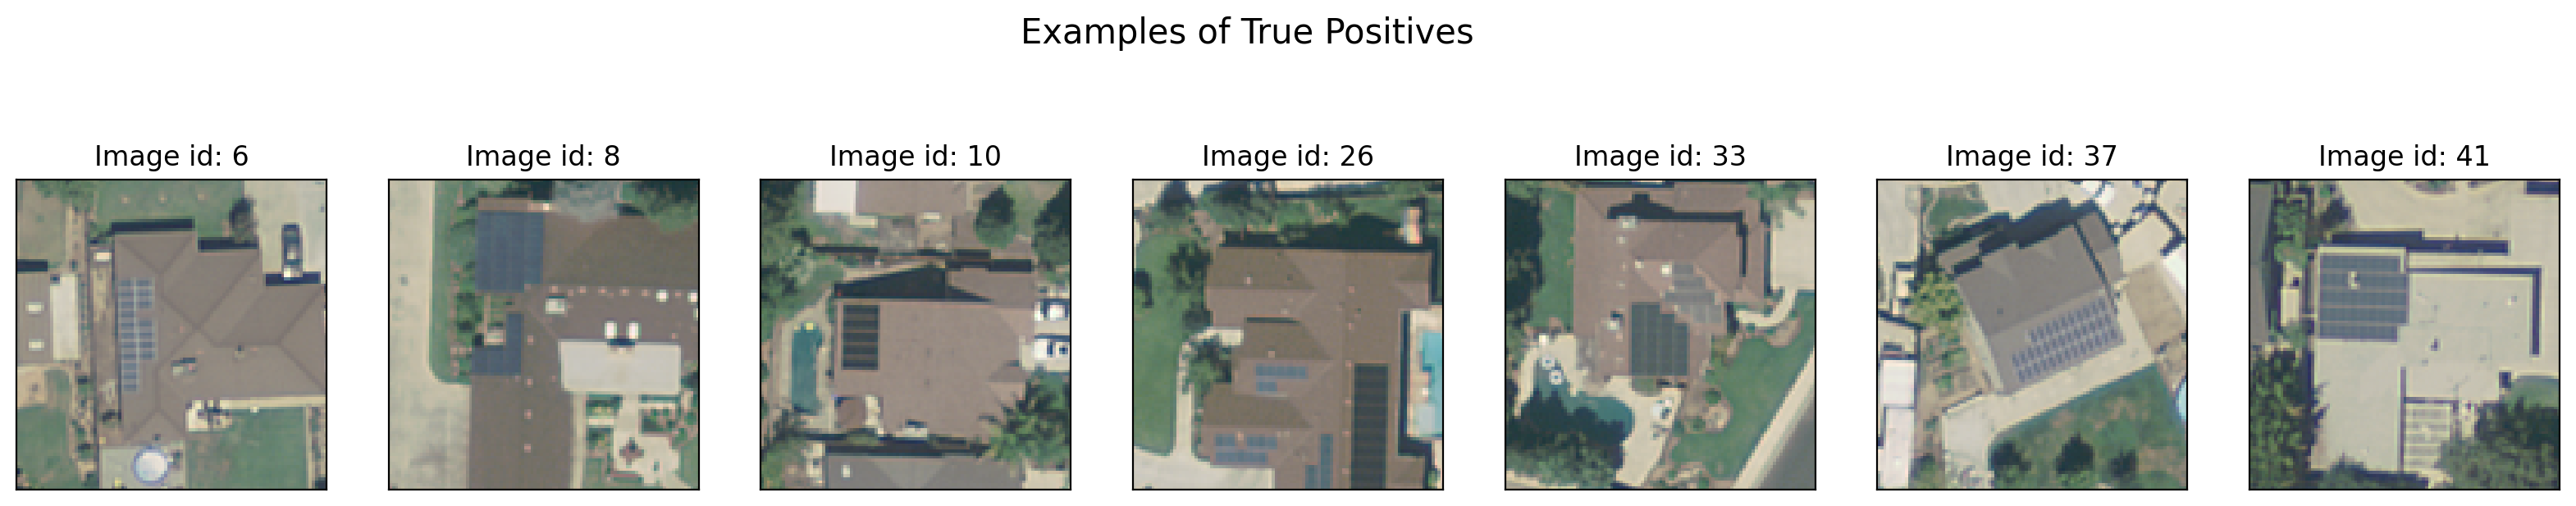

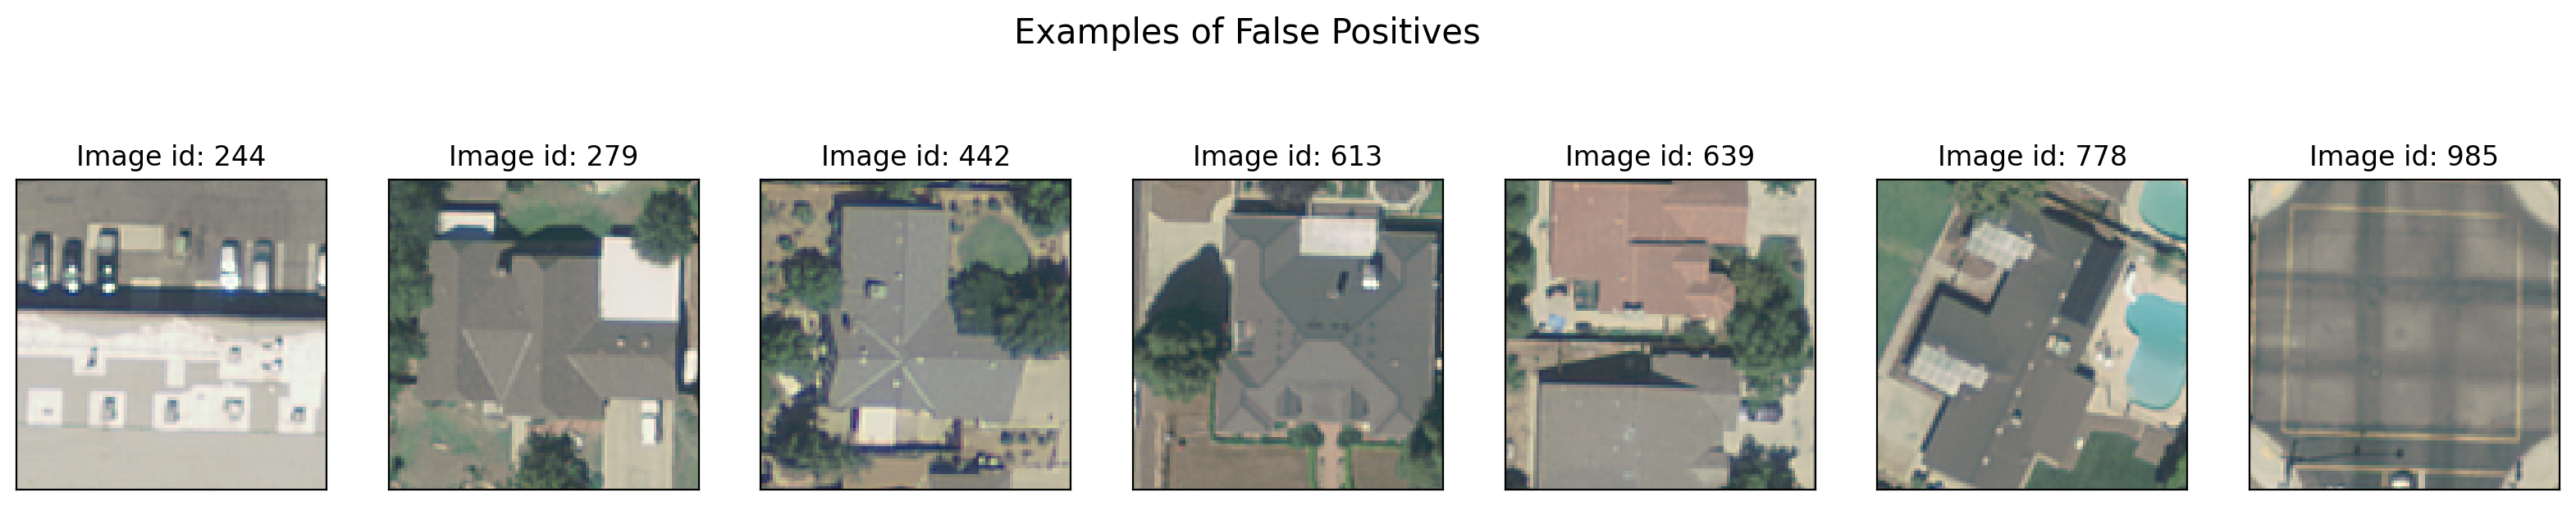

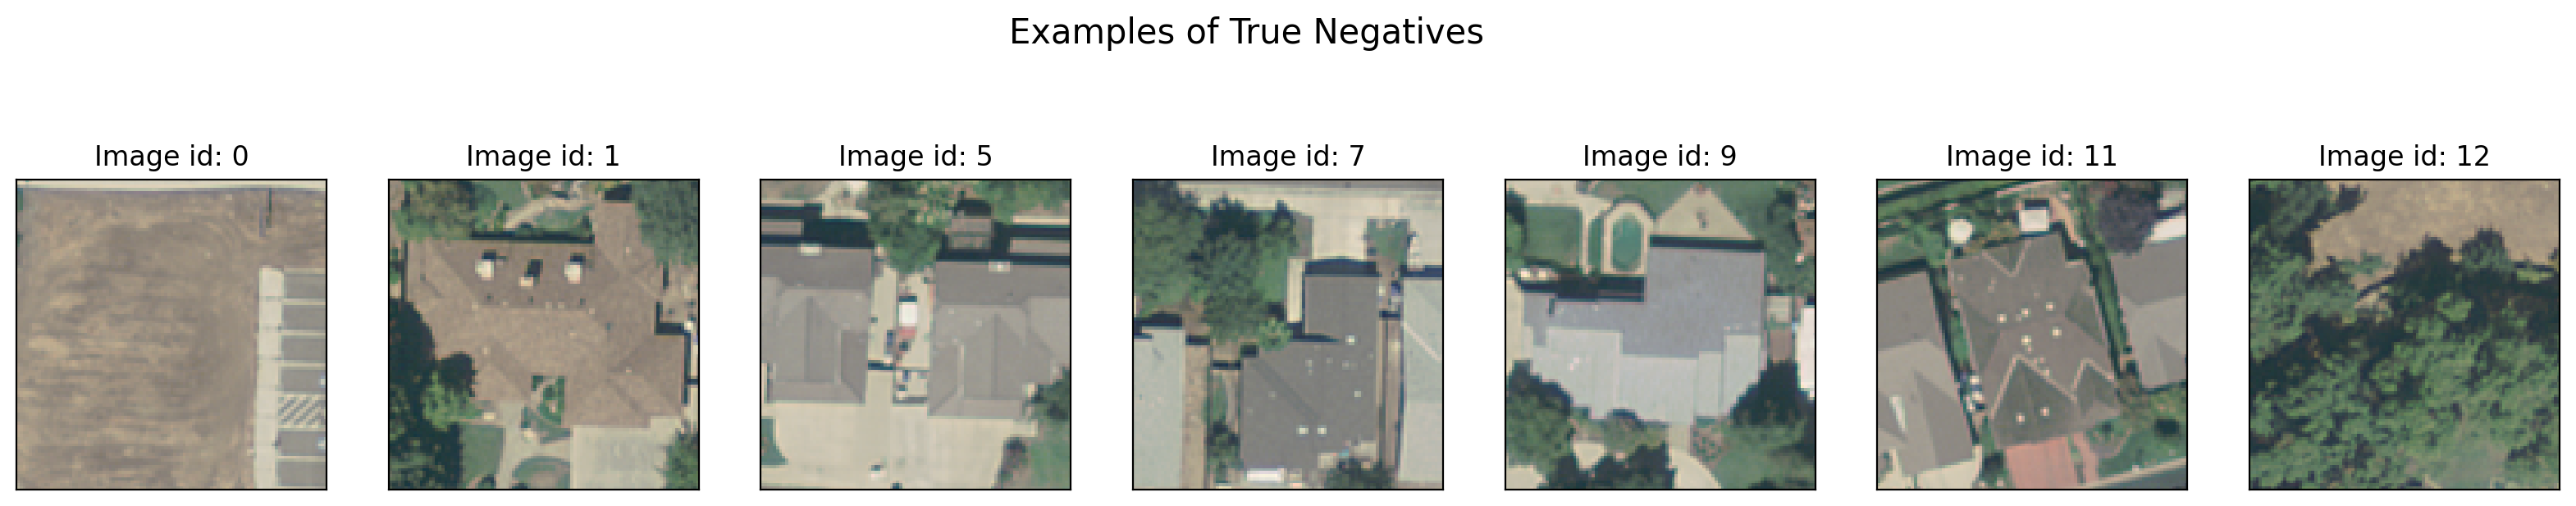

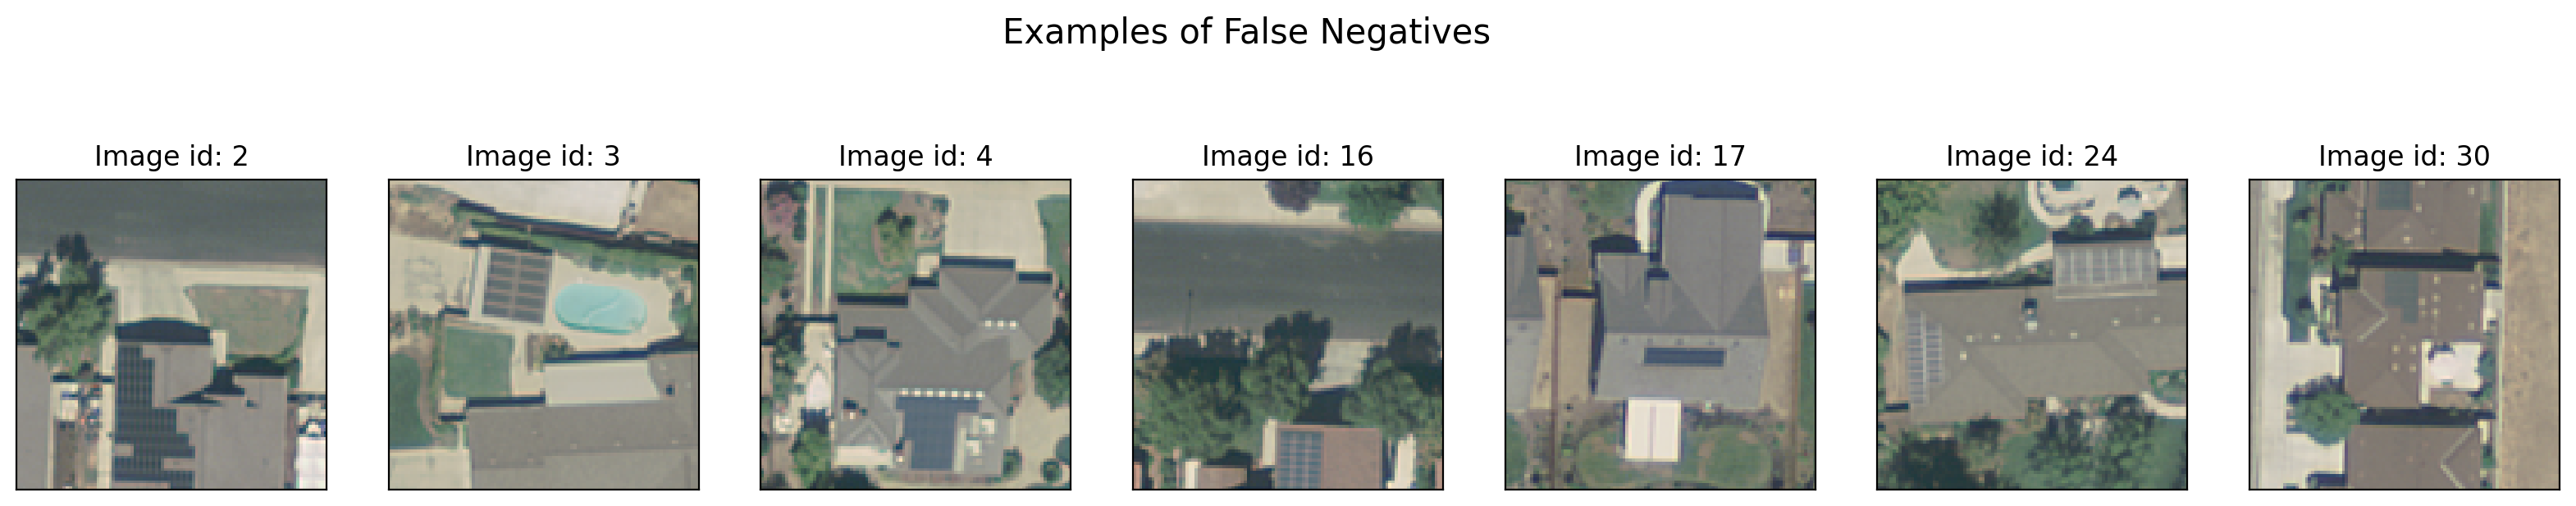

In [ ]:
num_images = 7  # number of images to look at
show_images(tp, num_images, 'Examples of True Positives')
show_images(fp, num_images, 'Examples of False Positives')
show_images(tn, num_images, 'Examples of True Negatives')
show_images(fn, num_images, 'Examples of False Negatives')


In [ ]:
'''
MODEL EVALUATION
'''

# compare all models based on ROC and PR curves
def plot_roc(y_true, y_pred_baseline, y_pred_knn, y_pred_cnn):
    '''
    Plots ROC curves for the baseline, KNN and CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of KNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_knn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_knn)
    legend_string = 'HOG and KNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='green', label=legend_string)

    # ROC of baseline model
    fpr, tpr, _ = roc_curve(y_true, y_pred_baseline, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_baseline)
    legend_string = 'Baseline Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='blue', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass


def plot_pr(y_true, y_pred_baseline, y_pred_knn, y_pred_cnn):
    '''
    Plots precision-recall (PR) curves for the baseline, KNN and CNN models.
    '''

    plt.figure(figsize=(8, 8))

    # PR of CNN
    precision, recall, _ = precision_recall_curve(y_true, y_pred_cnn, pos_label=1)
    legend_string = 'CNN Model'
    plt.plot(precision, recall, color='red', label=legend_string)

    # PR of KNN
    precision, recall, _ = precision_recall_curve(y_true, y_pred_knn, pos_label=1)
    legend_string = 'HOG and KNN'
    plt.plot(precision, recall, color='green', label=legend_string)

    # PR of baseline model
    precision, recall, _ = precision_recall_curve(y_true, y_pred_baseline, pos_label=1)
    legend_string = 'Baseline Model'
    plt.plot(precision, recall, color='blue', label=legend_string)

    # PR of chance
    p_r = np.random.randint(2, size=len(y_true))
    precision_r, recall_r, _ = precision_recall_curve(y_true, p_r, pos_label=1)
    legend_string_r = 'Chance'
    plt.plot(precision_r, recall_r, '--', color='gray', label=legend_string_r)

    # plot aesthetics
    plt.xlim([0, 1])
    plt.legend()
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid('on')
    plt.tight_layout()
    plt.title('Precision-Recall Curve', fontsize=10)
    pass



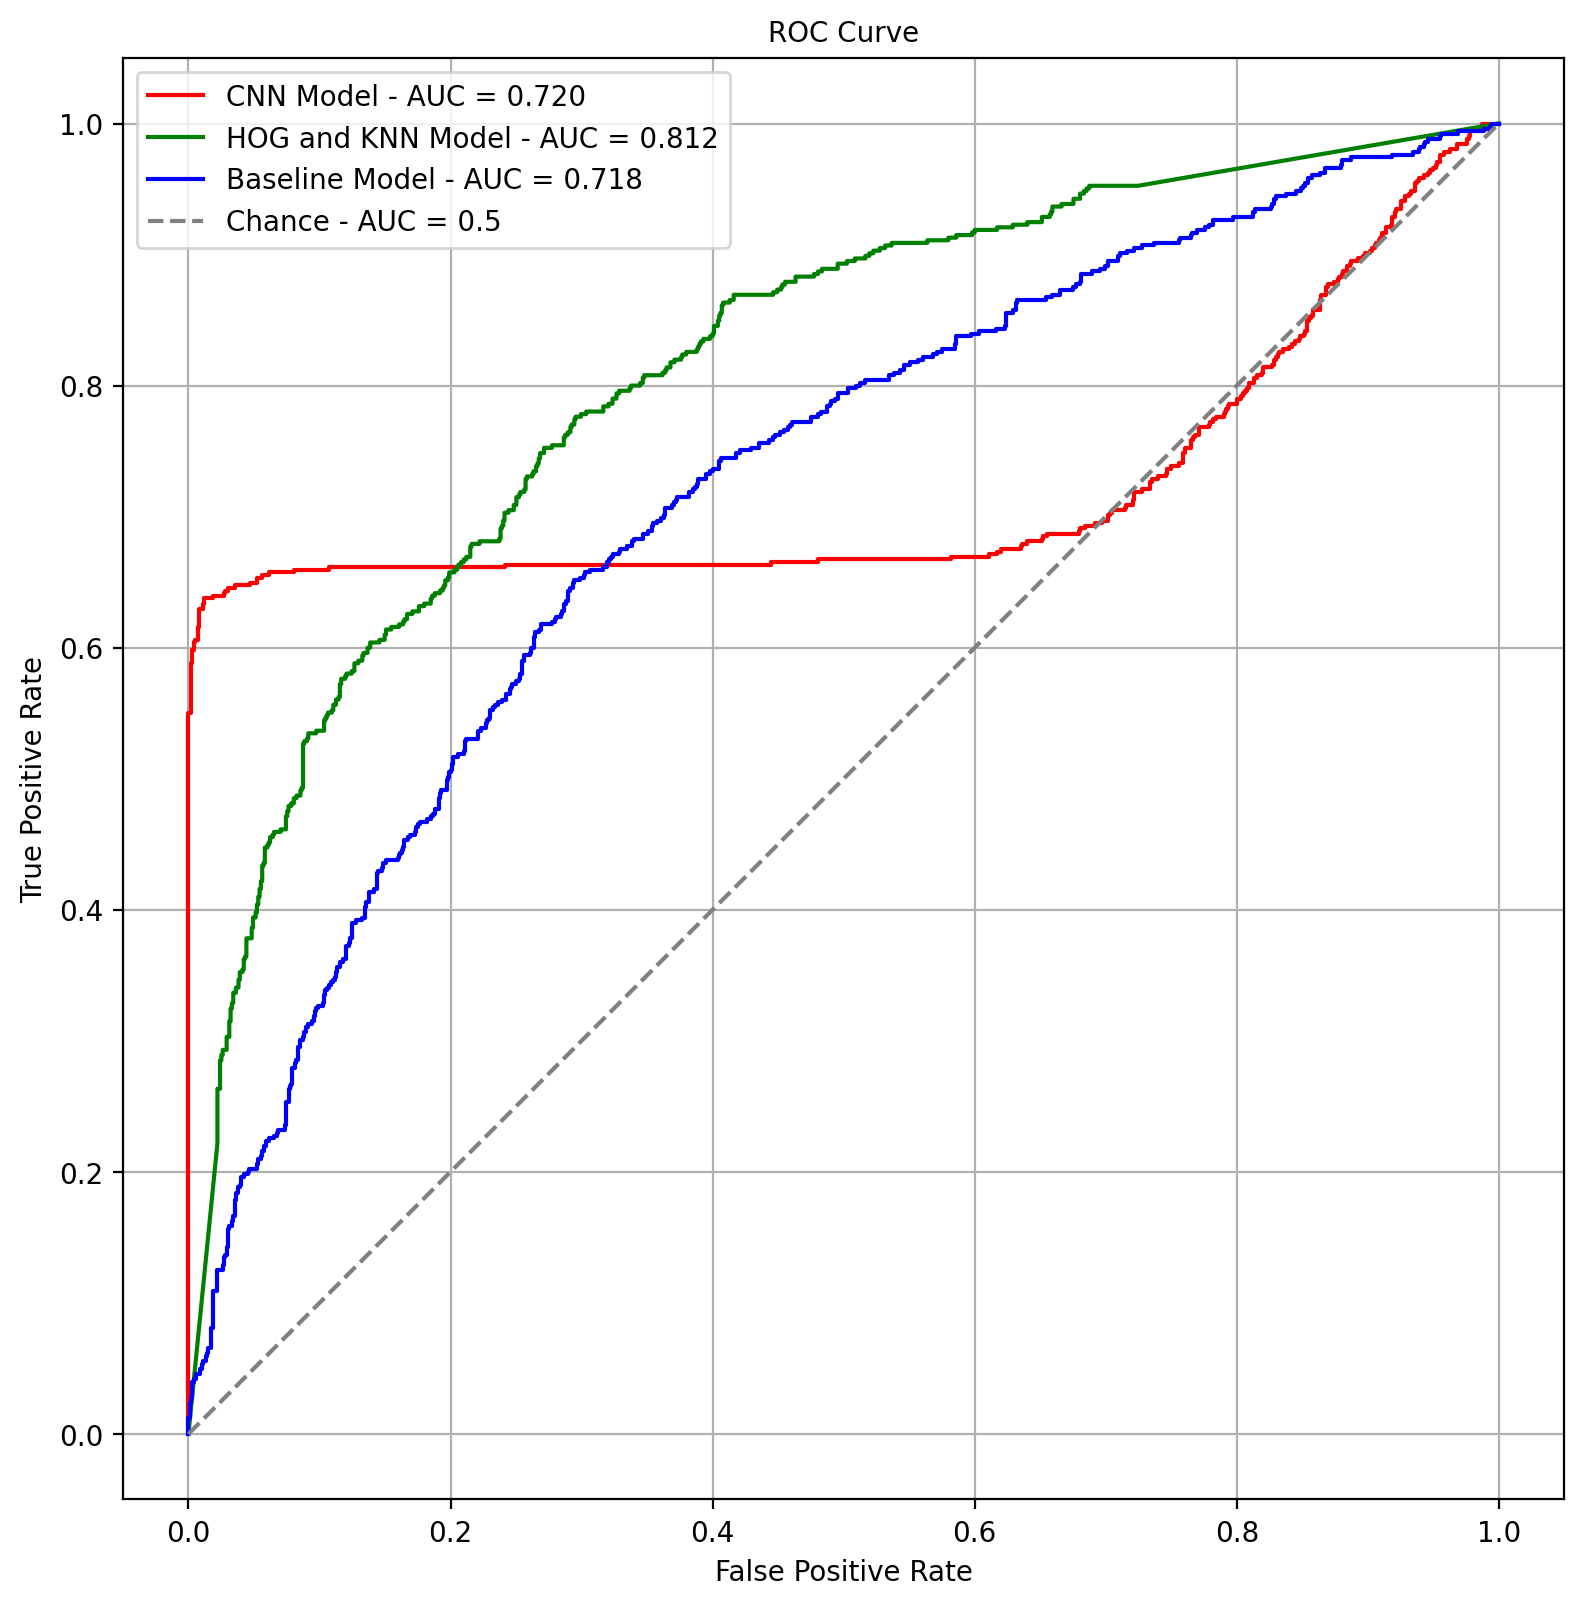

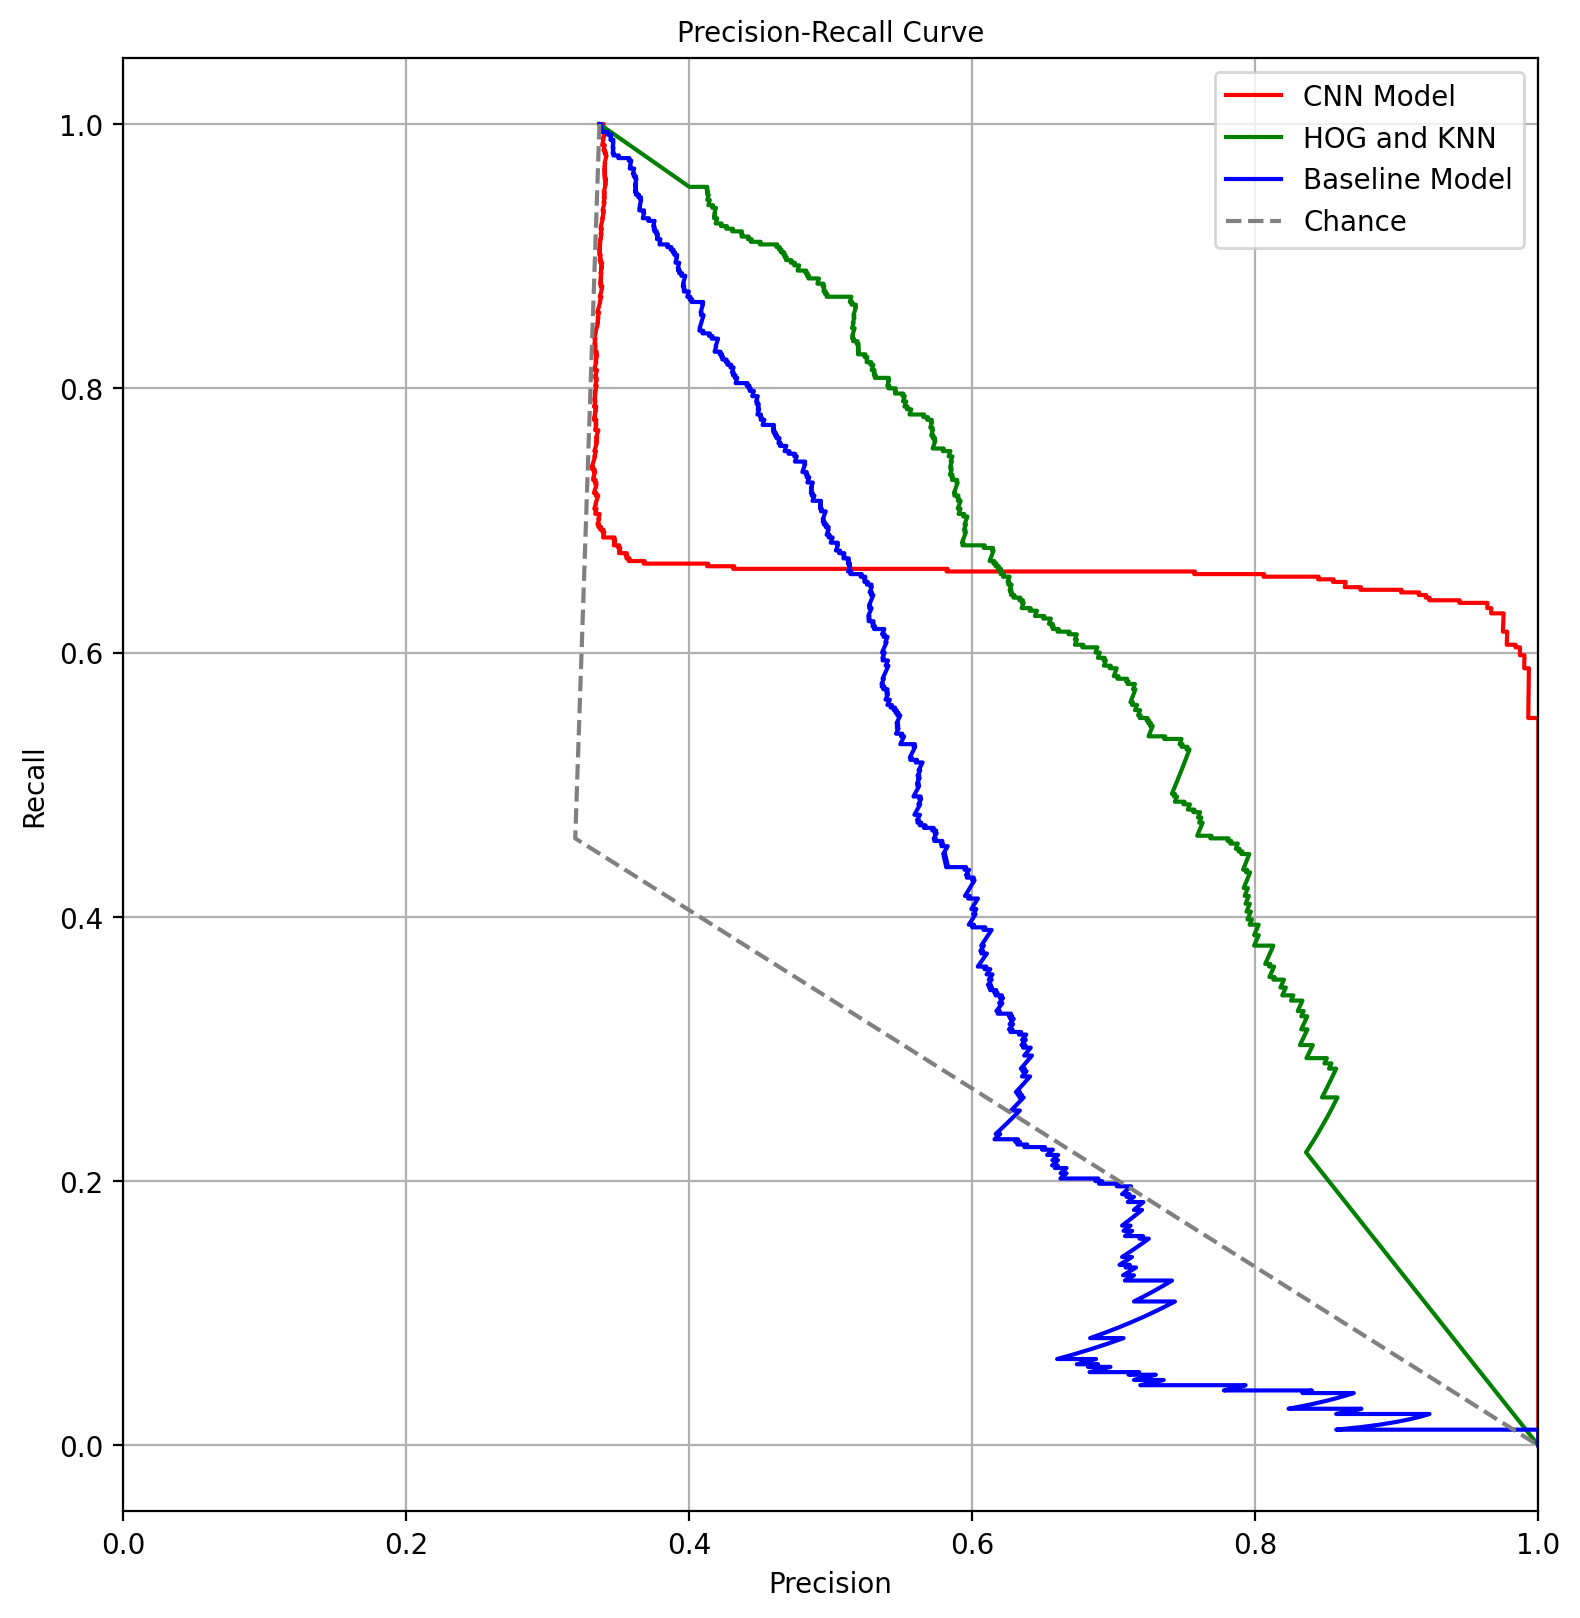

In [ ]:
# plot ROC and PR curves
plot_roc(y, baseline_y_hat_prob, hog_knn_y_hat_prob, cnn_y_hat_prob)
plot_pr(y, baseline_y_hat_prob, hog_knn_y_hat_prob, cnn_y_hat_prob)

In [ ]:
# cross-validate CNN model
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment
    Input:
        X   : training data
        y   : training labels
        k   : number of folds for cross validation
        clf : classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')
    prediction_class = np.empty(y.shape[0], dtype='object')

    # establish the k folds
    random_seed = 1
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    for train_index, val_index in kf.split(X, y):
        # extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        # give more weight to minority class based on the target class distribution
        class_weight = {0: 505/1500, 1: 995/1500}

        # train the classifier
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=40,
                           shuffle=True,
                           verbose=0)

        # test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs

    return prediction_scores


num_folds      = 3
random_seed    = 1
cnn            = build_model()
cnn.summary()
cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

cnn_y_hat_prob

# # Look at TP, TN, FP, and FN
# df = pd.read_csv(DIR_TRAIN_LABELS)
# df["predicted_score"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]

# fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])
# fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])
# tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])
# tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])

# num_images = 7  # number of images to look at
# show_images(tp, num_images, 'Examples of True Positives')
# show_images(fp, num_images, 'Examples of False Positives')
# show_images(tn, num_images, 'Examples of True Negatives')
# show_images(fn, num_images, 'Examples of False Negatives')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 99, 99, 32)        896       
                                                                 
 batch_normalization_14 (Ba  (None, 99, 99, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_15 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_15 (Ba  (None, 97, 97, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 95, 95, 128)       73856     
                                                                 
 batch_normalization_16 (Ba  (None, 95, 95, 128)      

array([0.0008080858970060945, 2.449492512823781e-06, 0.011568563990294933,
       ..., 0.00012341882393229753, 0.00021169654792174697,
       0.9999397993087769], dtype=object)